In [1]:
from sympy.physics.units import current
from torchmetrics.functional import accuracy


class Config:
    DATASET_PATH = "../../Eye_Gaze_Models/RawGazeData/"
    
conf = Config()

In [2]:
from sklearn.preprocessing import StandardScaler
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

class GazeDataset(Dataset):
    CLASS_MAP = {
        'Inspection': 0,
        'Reading': 1,
        'Search': 2,
    }
    def __init__(self, data_files, selected_cols, seq_len, transform=None, interpolation_method='linear'):
        self.data_files = data_files
        self.selected_cols = selected_cols
        self.seq_len = seq_len
        self.transform = transform
        self.interpolation_method = interpolation_method
        
        self.data = []
        self.labels = []
        self.participant_ids = []
        
        for file in self.data_files:
            participant_id = file.split('/')[-1].split('_')[0]
            label = file.split('/')[-1].split('_')[1].split('.')[0]
            
            data = self.load_single_file(file)
            data = self.interpolate_data(data)
            sequences = self.split_data_into_sequences(data)
            
            sequences = np.array(sequences).astype(np.float32)
            
            self.data.extend(sequences)  # Append sequences to the dataset
            self.labels.extend([int(self.CLASS_MAP[label])] * len(sequences))
            self.participant_ids.extend([int(participant_id)] * len(sequences))
            
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)
        self.participant_ids = np.array(self.participant_ids)
        
    def load_single_file(self, file):
        data = pd.read_csv(file)
        data = data[self.selected_cols]
        return data
    
    def interpolate_data(self, data):
        # Interpolate missing values using the specified method
        data_interpolated = data.interpolate(method=self.interpolation_method, limit_direction='both')
        # Fill any remaining NaNs using forward fill and backward fill
        data_interpolated = data_interpolated.bfill().ffill()
        return data_interpolated.values
    
    def split_data_into_sequences(self, data):
        # split the data into sequences of length seq_len.
        sequences = [data[i:i + self.seq_len] for i in range(0, len(data), self.seq_len)]
        # remove the last sequence if it is not of length seq_len
        if len(sequences[-1]) != self.seq_len:
            sequences.pop()
        return sequences

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample, label


In [3]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics import Accuracy

# Define the PyTorch Lightning Module
class GazeRNN(pl.LightningModule):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 num_layers, 
                 num_classes, 
                 rnn_type='LSTM',
                 dropout=0,
                 learning_rate=0.001,
                 opt_step_size=5,
                 opt_gamma=0.1):
        super(GazeRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.opt_step_size = opt_step_size
        self.opt_gamma = opt_gamma

        # Choose between LSTM, GRU, or vanilla RNN
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        else:
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size, num_classes)

        # Loss function
        self.criterion = nn.CrossEntropyLoss()

        # Accuracy metric
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        if isinstance(self.rnn, nn.LSTM):
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.rnn(x, (h0, c0))
        else:
            out, _ = self.rnn(x, h0)

        # Take the last time-step's output
        out = out[:, -1, :]
        out = self.fc(out)
        return out

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = self.train_acc(outputs, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = self.val_acc(outputs, labels)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('lr', self.trainer.optimizers[0].param_groups[0]['lr'], on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=self.opt_step_size, gamma=self.opt_gamma)
        return [optimizer], [scheduler]


In [4]:
import os
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

class GazeDataModule(pl.LightningDataModule):
    def __init__(self, ds_train, ds_val, batch_size=64, num_workers=4):
        super(GazeDataModule, self).__init__()
        self.ds_train = ds_train
        self.ds_val = ds_val
        self.batch_size = batch_size
        self.num_workers = num_workers

    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


In [64]:
import pickle

col_of_interest = [
    # 'gazeOrigin_x', 'gazeOrigin_y', 'gazeOrigin_z', 
    # 'gazeDirection_x', 'gazeDirection_y', 'gazeDirection_z', 
    'gazePoint_x', 'gazePoint_y', 'gazePoint_z', 
    # 'gazePoint_target_x', 'gazePoint_target_y', 'gazePoint_target_z',
    # 'gazePoint_target_pos_x', 'gazePoint_target_pos_y', 'gazePoint_target_pos_z',
    # 'gazePoint_target_rot_x', 'gazePoint_target_rot_y', 'gazePoint_target_rot_z',
    # 'gazePointMonoScreen_x', 'gazePointMonoScreen_y', 'gazePointMonoScreen_z',
    # 'gazePoint_target_scale_x', 'gazePoint_target_scale_y', 'gazePoint_target_scale_z', 
    # 'gazePointLeftScreen_x', 'gazePointLeftScreen_y', 'gazePointLeftScreen_z', 
    # 'gazePointRightScreen_x', 'gazePointRightScreen_y', 'gazePointRightScreen_z'
]

dir_files = os.listdir(conf.DATASET_PATH)
test_participants = ['01', '02', '03', '04', '05']
train_files = [os.path.join(conf.DATASET_PATH, f) for f in dir_files if f.split('_')[0] not in test_participants]
test_files = [os.path.join(conf.DATASET_PATH, f) for f in dir_files if f.split('_')[0] in test_participants]

train_ds = GazeDataset(train_files, col_of_interest, 60)
test_ds = GazeDataset(test_files, col_of_interest, 60)

scaler = StandardScaler()
all_data = np.concatenate([train_ds.data, test_ds.data])
scaler.fit(all_data.reshape(-1, all_data.shape[-1]))

with open('.local/scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)

train_ds.data = scaler.transform(train_ds.data.reshape(-1, train_ds.data.shape[-1])).reshape(train_ds.data.shape)
test_ds.data = scaler.transform(test_ds.data.reshape(-1, test_ds.data.shape[-1])).reshape(test_ds.data.shape)

print(f"Number of samples in train dataset: {len(train_ds)}")
print(f"Number of samples in test dataset: {len(test_ds)}")
print(f"shape of each sample: {train_ds[0][0].shape}")

Number of samples in train dataset: 1526
Number of samples in test dataset: 492
shape of each sample: (60, 3)


In [66]:
from pytorch_lightning.loggers import TensorBoardLogger
from datetime import datetime
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
from pytorch_lightning.callbacks import RichProgressBar

# Hyperparameters
INPUT_SIZE = len(col_of_interest)
HIDDEN_SIZE = 32
NUM_LAYERS = 2
NUM_CLASSES = 3
LEARNING_RATE = 0.001
MODEL_TYPE = 'LSTM'
DROPOUT = 0.3

BATCH_SIZE = 64
NUM_WORKERS = 4

NUM_EPOCHS = 50
OPT_STEP_SIZE = 10
OPT_GAMMA = 0.9


# Initialize the DataModule
data_module = GazeDataModule(
    train_ds, test_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

# Initialize the model
model = GazeRNN(
    input_size=len(col_of_interest),
    hidden_size=HIDDEN_SIZE, 
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES, 
    learning_rate=LEARNING_RATE,
    rnn_type=MODEL_TYPE,
    opt_step_size=OPT_STEP_SIZE,
    opt_gamma=OPT_GAMMA,
    dropout=DROPOUT
)

# Checkpoint callback
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M')
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'checkpoints/{MODEL_TYPE}/{current_time}',
    filename='gaze_rnn-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',
)

# Initialize PyTorch Lightning trainer
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS, 
    accelerator='gpu', 
    enable_progress_bar=True,
    logger=False,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback]
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/tobias/Desktop/Uni/IMP/IMP_Magical_Gaze-based_Device_Control/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/tobias/Desktop/Uni/IMP/IMP_Magical_Gaze-based_Device_Control/checkpoints/LSTM/2024-09-23_17-26 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | rnn       | LSTM               | 13.2 K | train
1 | fc        | Linear             | 99     | train
2 | criterion | CrossEntropyLoss   | 0      | train
3 | train_acc | MulticlassAccuracy | 0      | train
4 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated mode

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [67]:
# Load the best model from the checkpoint
best_model = GazeRNN.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES,
    rnn_type=MODEL_TYPE,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE,
    opt_step_size=OPT_STEP_SIZE,
    opt_gamma=OPT_GAMMA
)

# Predict on the validation set and set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)
best_model.eval()

# Initialize the DataLoader for the validation set
val_loader = data_module.val_dataloader()

# Predict on the validation set
y_true = []
y_pred = []
for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = best_model(inputs)
    _, predicted = torch.max(outputs, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())
    
# Calculate the accuracy
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.8191056910569106


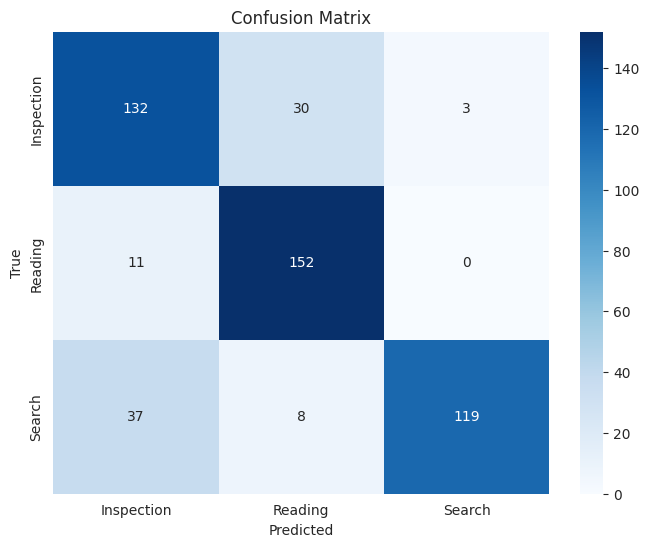

In [68]:
# Plot the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=GazeDataset.CLASS_MAP.keys(), yticklabels=GazeDataset.CLASS_MAP.keys(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [69]:
import pandas as pd
import zmq
import cv2
import numpy as np
from PIL import Image
import msgpack


class PupilCapture:

    def __init__(self, ip='localhost', port=50020):
        self.ctx = zmq.Context()
        # The REQ talks to Pupil remote and receives the session unique IPC SUB PORT
        self.pupil_remote = self.ctx.socket(zmq.REQ)
        self.ip = ip

        self.pupil_remote.connect(f'tcp://{self.ip}:{port}')

        # Request 'SUB_PORT' for reading data
        self.pupil_remote.send_string('SUB_PORT')
        self.sub_port = self.pupil_remote.recv_string()

        # Request 'PUB_PORT' for writing data
        self.pupil_remote.send_string('PUB_PORT')
        self.pub_port = self.pupil_remote.recv_string()



    def receive_frame_world_image(self, num_frames=1):
        sub_frame_world = self.ctx.socket(zmq.SUB)
        sub_frame_world.connect(f'tcp://{self.ip}:{self.sub_port}')
        sub_frame_world.subscribe("frame.world")

        frames = []
        for _ in range(num_frames):
            frame = sub_frame_world.recv_multipart()
            image_bytes = frame[2]
            decoded_frame = cv2.imdecode(np.frombuffer(image_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)
            rgb_frame = cv2.cvtColor(decoded_frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(rgb_frame)
            frames.append(img)
        return frames

    def receive_gaze_3d_position(self, num_gazes=1):
        subscriber = self.ctx.socket(zmq.SUB)
        subscriber.connect(f'tcp://{self.ip}:{self.sub_port}')
        subscriber.subscribe('gaze.')  # receive all gaze messages

        gazes = []
        for _ in range(num_gazes):
            topic, payload = subscriber.recv_multipart()
            message = msgpack.loads(payload)
            gaze = message['gaze_point_3d'.encode()]
            gazes.append(gaze)
        return gazes

In [83]:
pupil_cap = PupilCapture()

for i in range(20):
    gaze_sample = pupil_cap.receive_gaze_3d_position(60)
    gaze_sample = np.array(gaze_sample)
    # downsample from 120 Hz to 30 Hz
    scaler_1 = StandardScaler()
    # scale column wise
    gaze_sample = scaler_1.fit_transform(gaze_sample.reshape(-1, gaze_sample.shape[-1])).reshape(gaze_sample.shape)
    gaze_sample = torch.tensor(gaze_sample, dtype=torch.float32).unsqueeze(0)
    
    best_model.eval()
    with torch.no_grad():
        gaze_sample = gaze_sample.to(device)
        outputs = best_model(gaze_sample)
        _, predicted = torch.max(outputs, 1)
    predicted_class = list(GazeDataset.CLASS_MAP.keys())[predicted.item()]
    print(f"Predicted class: {predicted_class}")

Predicted class: Search
Predicted class: Inspection
Predicted class: Inspection
Predicted class: Inspection
Predicted class: Inspection
Predicted class: Reading
Predicted class: Reading
Predicted class: Search
Predicted class: Reading
Predicted class: Reading
Predicted class: Reading
Predicted class: Reading
Predicted class: Search
Predicted class: Search
Predicted class: Search
Predicted class: Search
Predicted class: Search
Predicted class: Search
Predicted class: Search
Predicted class: Search
